In [1]:
import pandas as pd
import os

### The visualisations in this script show resultsbased on the modelling tasks guided by the following settings:- 

## Models
- **Embedding Model**: `all-MiniLM-L6-v2` (SentenceTransformer)
- **LLM Model**: `mistralai/Mistral-7B-Instruct-v0.3` (Not available/used - fallback to KeyBERT)
- **Clustering**: HDBSCAN

## Key Parameters
- **PCA Components**: 75  
- **HDBSCAN**:
  - `min_cluster_size`: auto (1% of data, min 5)
  - `min_samples`: 1
  - `metric`: euclidean
  - `cluster_selection_method`: leaf
  - `cluster_selection_epsilon`: 0.5

## Keyword Generation (Fallback)
- **Method**: KeyBERT when LLM unavailable
- **Parameters**:
  - `keyphrase_ngram_range`: (1, 2)
  - `stop_words`: english
  - `top_n`: 5 (per question)
  - Minimum keyword frequency thresholds:
    - Main clusters: ≥3 occurrences
    - Subclusters: ≥2 occurrences

## Metrics
- **Silhouette Score**
- **Calinski-Harabasz Index**
- **Davies-Bouldin Index**
- **Cluster Statistics**:
  - Number of clusters
  - Noise points
  - Average cluster size

In [2]:
df = pd.read_csv('./Clinical_Cluster_Outputs/clinical_cluster_summary.csv')
df.head()

,cluster,size,keywords,representative_comment,representative_question
0,1,3680,"['peer unfit', 'people boring', 'married loser...",used always joke depressed hating life past mo...,I used to always just joke about being depress...
1,noise_cluster,2162,"['boring person', 'earn peer', 'failure stylis...",year old aromantic tell anymore feel mentally ...,"I鈥檓 14 years old, I鈥檓 aromantic, and I can鈥檛 ..."
2,0,122,"['friend culinary', 'wedding dislike', 'invita...",friend invite dinner party must enjoy company,My friend didn't invite me to their dinner pa...
3,2,93,"['leader project', 'idea rejected', 'think sma...",chosen project skill must lacking,I wasn't chosen for the project my skills mus...


##### The above shos the results of the first level (1st layer clustering) which produced 3 clusters and an additional noise cluster.
##### The intuition behind labelling noise as cluster is on the fact that quantitative value does not mean qualitative lack of value.
##### The noise clusters may contain micro clusters that have meaningful information especially when dealing with social construct and
##### and in clinically related experiments. It might be the onset of a health relatesd issue as such there is need to probe into these
##### minimal or micro clusters for futher analytical review.

In [3]:
df1 = pd.read_csv('./Clinical_Cluster_Outputs/cluster_details/cluster_0.csv')
df1.head()

,patient_question,cleaned_text,keywords,distance_to_centroid
0,My friend didn't invite me to the party I mus...,friend invite party must terrible friend,"['invite party', 'party terrible', 'terrible f...",0.704716
1,I can't cook as well as my mom I'm not a good...,cook well mom good homemaker,"['cook mom', 'good homemaker', 'homemaker', 'm...",0.421700
2,I wasn't invited to the meeting my opinions d...,invited meeting opinion matter,"['meeting opinion', 'invited meeting', 'meetin...",0.514285
3,I wasn't invited to their wedding they must d...,invited wedding must dislike,"['wedding dislike', 'invited wedding', 'weddin...",0.621622
4,My friends didn't include me in their plans t...,friend include plan must find boring,"['plan boring', 'include plan', 'friend includ...",0.573654


In [4]:
df2 = pd.read_csv('./Clinical_Cluster_Outputs/cluster_details/cluster_1.csv')
df2.head()

,patient_question,cleaned_text,keywords,distance_to_centroid
0,I'm such a failure I never do anything right.,failure never anything right,"['failure right', 'failure', 'right']",0.323038
1,My boss didn't say 'good morning' she must be...,bos say good morning must angry,"['morning angry', 'morning', 'bos say', 'good ...",0.281972
2,Nobody cares about me because they didn't ask...,nobody care ask day,"['ask day', 'care ask', 'care', 'day', 'ask']",0.197227
3,My partner didn't say 'I love you' today our ...,partner say love today relationship must falli...,"['relationship falling', 'falling apart', 'tod...",0.385994
4,My child misbehaved at school I must be a bad...,child misbehaved school must bad parent,"['misbehaved school', 'child misbehaved', 'bad...",0.313729


In [5]:
df3 = pd.read_csv('./Clinical_Cluster_Outputs/cluster_details/cluster_2.csv')
df3.head()

,patient_question,cleaned_text,keywords,distance_to_centroid
0,My idea was rejected my team must think I'm d...,idea rejected team must think dumb,"['idea rejected', 'rejected team', 'think dumb...",0.577736
1,I didn't get the promotion I will never progr...,get promotion never progress career,"['promotion progress', 'promotion', 'progress ...",0.345262
2,I wasn't promoted I'm a failure at my job.,promoted failure job,"['promoted failure', 'failure job', 'promoted'...",0.403485
3,I wasn't selected for the project my ideas mu...,selected project idea must worthless,"['idea worthless', 'project idea', 'selected p...",0.635969
4,I didn't get the raise my work is not appreci...,get raise work appreciated,"['raise work', 'raise', 'work', 'work apprecia...",0.413817


In [8]:
df4 = pd.read_csv('./Clinical_Cluster_Outputs/cluster_details/noise_cluster.csv')
df4.head()

,patient_question,cleaned_text,keywords,distance_to_centroid
0,Nobody likes me because I'm not interesting.,nobody like interesting,"['like interesting', 'interesting', 'like']",0.247387
1,I can't try new things because I'll just mess...,try new thing mess,"['thing mess', 'try new', 'mess', 'new thing',...",0.282968
2,I didn't get the job so I must be incompetent.,get job must incompetent,"['job incompetent', 'incompetent', 'job']",0.295849
3,I'm always unlucky. Good things only happen t...,always unlucky good thing happen people,"['unlucky good', 'unlucky', 'happen people', '...",0.359713
4,Everyone thinks I'm stupid because I made a m...,everyone think stupid made mistake presentation,"['mistake presentation', 'stupid mistake', 'pr...",0.386791


##### The above results show each patient question, the patient question respective cluster, keywords in the question which generally points to the nature of cognitive distortion and distance to the centroid. This information can be explord further to find out for example whether the centroid is positive expression and distance from that centroid is based on how close or how far is a patient question to that state of distortion or lack of it #####

In [10]:
df5 = pd.read_csv('./Clinical_Cluster_Outputs/clinical_cluster_summary.csv')
df5

,cluster,size,keywords,representative_comment,representative_question
0,1,3680,"['peer unfit', 'people boring', 'married loser...",used always joke depressed hating life past mo...,I used to always just joke about being depress...
1,noise_cluster,2162,"['boring person', 'earn peer', 'failure stylis...",year old aromantic tell anymore feel mentally ...,"I鈥檓 14 years old, I鈥檓 aromantic, and I can鈥檛 ..."
2,0,122,"['friend culinary', 'wedding dislike', 'invita...",friend invite dinner party must enjoy company,My friend didn't invite me to their dinner pa...
3,2,93,"['leader project', 'idea rejected', 'think sma...",chosen project skill must lacking,I wasn't chosen for the project my skills mus...


In [17]:

cluster_1_keywords = df.loc[0, 'keywords']
print(cluster_1_keywords)

['peer unfit', 'people boring', 'married loser', 'instagram unattractive', 'wish friend', 'likable significant', 'anniversary love', 'like toned', 'receive retweets', 'return avoiding']


In [18]:

noise_cluster_keywords = df.loc[1, 'keywords']
print(noise_cluster_keywords)

['boring person', 'earn peer', 'failure stylish', 'list unproductive', 'essay terrible', 'paper smart', 'think competent', 'exam pressure', 'thing happen', 'weight mean']


In [19]:

cluster_0_keywords = df.loc[2, 'keywords']
print(cluster_0_keywords)

['friend culinary', 'wedding dislike', 'invitation exclusive', 'partner compliment', 'decorate cake', 'housewarming party', 'session idea', 'make souffl', 'display painting', 'teacher lack']


In [20]:

cluster_2_keywords = df.loc[3, 'keywords']
print(cluster_2_keywords)

['leader project', 'idea rejected', 'think smart', 'join study', 'trust teacher', 'interview potential', 'skill lacking', 'receive raise', 'appreciate effort', 'duolingo polyglot']


##### The above visualisations generally show the main clusters and their keywords, number of patient questions per cluster.

##   Quantitative Metrics

In [21]:
import json

In [23]:
with open ('./Clinical_Cluster_Outputs/cluster_metrics.json') as f:
    data = json.load(f)
    print(json.dumps(data, indent=4))

{
    "cluster_stats": {
        "n_clusters": 3,
        "n_noise_points": 2162,
        "avg_cluster_size": 1298.3333333333333,
        "cluster_size_distribution": {
            "1": 3680,
            "0": 122,
            "2": 93
        }
    },
    "silhouette_score": 0.09763918817043304,
    "calinski_harabasz_score": 30.204289392289134,
    "davies_bouldin_score": 4.036162556673001
}


In [3]:
import json
with open ('/Users/samsonbobo/Desktop/submission folder/PCA_75/cluster_metrics.json') as f:
    data = json.load(f)
    print(json.dumps(data, indent=4))

{
    "primary_space": "PCA_reduced",
    "cluster_stats": {
        "n_clusters": 3,
        "n_noise_points": 2162,
        "avg_cluster_size": 1298.3333333333333,
        "cluster_size_distribution": {
            "1": 3680,
            "0": 122,
            "2": 93
        }
    },
    "PCA_reduced": {
        "silhouette_score": 0.09763918817043304,
        "calinski_harabasz_score": 30.204289392289134,
        "davies_bouldin_score": 4.036162556673001
    },
    "original": {
        "silhouette_score": 0.12354118376970291,
        "calinski_harabasz_score": 63.54640908268058,
        "davies_bouldin_score": 3.2125429761815076
    },
    "distance_preservation": {
        "distance_correlation": 0.766060439585678
    }
}


#####   The silhoutte score is quite low for this dataset, the prefferable score is >0.5...The score was computed base on PCA embeddings. However, the score computed against original embeddings that is the first instance embeddings recorded a score of 0.1235

#   SUB CLUSTERING VISUALISATIONS
#### Please check the sub_clustering.py script for the code steps

In [24]:
df7 = pd.read_csv('./cluster_analysis_output.csv')
df7.head()

,patient_question,Cluster,Main_Cluster_Label,Subcluster_Label,Cluster_Keywords,Subcluster_Keywords
0,I'm such a failure I never do anything right.,1,Peer Unfit People Boring,depressed,"peer unfit, people boring, married loser, inst...",depressed
1,My boss didn't say 'good morning' she must be...,1,Peer Unfit People Boring,bipolar,"peer unfit, people boring, married loser, inst...",bipolar
2,Nobody cares about me because they didn't ask...,1,Peer Unfit People Boring,don鈥檛 feel,"peer unfit, people boring, married loser, inst...",don鈥檛 feel
3,My partner didn't say 'I love you' today our ...,1,Peer Unfit People Boring,relationship,"peer unfit, people boring, married loser, inst...",relationship
4,My child misbehaved at school I must be a bad...,1,Peer Unfit People Boring,parents,"peer unfit, people boring, married loser, inst...",parents


In [25]:
import pandas as pd

# Load the data
df7 = pd.read_csv('./cluster_analysis_output.csv')

# Get unique clusters
unique_clusters = df7['Cluster'].unique()

# Display first 5 rows for each cluster
for cluster in unique_clusters:
    print(f"\n=== Cluster {cluster} ===")
    display(df7[df7['Cluster'] == cluster].head(5))


=== Cluster 1 ===


,patient_question,Cluster,Main_Cluster_Label,Subcluster_Label,Cluster_Keywords,Subcluster_Keywords
0,I'm such a failure I never do anything right.,1,Peer Unfit People Boring,depressed,"peer unfit, people boring, married loser, inst...",depressed
1,My boss didn't say 'good morning' she must be...,1,Peer Unfit People Boring,bipolar,"peer unfit, people boring, married loser, inst...",bipolar
2,Nobody cares about me because they didn't ask...,1,Peer Unfit People Boring,don鈥檛 feel,"peer unfit, people boring, married loser, inst...",don鈥檛 feel
3,My partner didn't say 'I love you' today our ...,1,Peer Unfit People Boring,relationship,"peer unfit, people boring, married loser, inst...",relationship
4,My child misbehaved at school I must be a bad...,1,Peer Unfit People Boring,parents,"peer unfit, people boring, married loser, inst...",parents



=== Cluster noise_cluster ===


,patient_question,Cluster,Main_Cluster_Label,Subcluster_Label,Cluster_Keywords,Subcluster_Keywords
3680,Nobody likes me because I'm not interesting.,noise_cluster,Boring Person Earn Peer,don,"boring person, earn peer, failure stylish, lis...",don
3681,I can't try new things because I'll just mess...,noise_cluster,Boring Person Earn Peer,don,"boring person, earn peer, failure stylish, lis...",don
3682,I didn't get the job so I must be incompetent.,noise_cluster,Boring Person Earn Peer,successful,"boring person, earn peer, failure stylish, lis...",successful
3683,I'm always unlucky. Good things only happen t...,noise_cluster,Boring Person Earn Peer,anxiety,"boring person, earn peer, failure stylish, lis...",anxiety
3684,Everyone thinks I'm stupid because I made a m...,noise_cluster,Boring Person Earn Peer,smart,"boring person, earn peer, failure stylish, lis...",smart



=== Cluster 0 ===


,patient_question,Cluster,Main_Cluster_Label,Subcluster_Label,Cluster_Keywords,Subcluster_Keywords
5842,My friend didn't invite me to the party I mus...,0,Friend Culinary Wedding Dislike,wasn invited,"friend culinary, wedding dislike, invitation e...",wasn invited
5843,I can't cook as well as my mom I'm not a good...,0,Friend Culinary Wedding Dislike,cook,"friend culinary, wedding dislike, invitation e...",cook
5844,I wasn't invited to the meeting my opinions d...,0,Friend Culinary Wedding Dislike,wasn invited,"friend culinary, wedding dislike, invitation e...",wasn invited
5845,I wasn't invited to their wedding they must d...,0,Friend Culinary Wedding Dislike,wedding,"friend culinary, wedding dislike, invitation e...",wedding
5846,My friends didn't include me in their plans t...,0,Friend Culinary Wedding Dislike,friends didn,"friend culinary, wedding dislike, invitation e...",friends didn



=== Cluster 2 ===


,patient_question,Cluster,Main_Cluster_Label,Subcluster_Label,Cluster_Keywords,Subcluster_Keywords
5964,My idea was rejected my team must think I'm d...,2,Leader Project Idea Rejected,think dumb,"leader project, idea rejected, think smart, jo...",think dumb
5965,I didn't get the promotion I will never progr...,2,Leader Project Idea Rejected,promotion,"leader project, idea rejected, think smart, jo...",promotion
5966,I wasn't promoted I'm a failure at my job.,2,Leader Project Idea Rejected,promoted,"leader project, idea rejected, think smart, jo...",promoted
5967,I wasn't selected for the project my ideas mu...,2,Leader Project Idea Rejected,project didn,"leader project, idea rejected, think smart, jo...",project didn
5968,I didn't get the raise my work is not appreci...,2,Leader Project Idea Rejected,raise,"leader project, idea rejected, think smart, jo...",raise


In [30]:
df8 = pd.read_csv('/Users/samsonbobo/Desktop/Final_Experiments/subcluster_distribution.csv')
df8

,Main_Cluster_Label,Subcluster_Label,Count
0,Boring Person Earn Peer,anxiety,204
1,Boring Person Earn Peer,boyfriend,68
2,Boring Person Earn Peer,can鈥檛,67
3,Boring Person Earn Peer,didn,108
4,Boring Person Earn Peer,doesn鈥檛,61
...,...,...,...
72,Peer Unfit People Boring,schizophrenia,86
73,Peer Unfit People Boring,schizophrenic,102
74,Peer Unfit People Boring,social anxiety,214
75,Peer Unfit People Boring,therapist,64


In [3]:
#Subcluster statistics summarisation
import pandas as pd

# Load the CSV file
df = pd.read_csv('subcluster_statistics.csv')

# 1. Number of subclusters per main cluster
subclusters_per_cluster = df.groupby(['Main_Cluster', 'Main_Cluster_Label'])['Subcluster_Label'] \
                            .count() \
                            .reset_index() \
                            .rename(columns={'Subcluster_Label': 'Subcluster_Count'})

# 2. Question count per sub-cluster (this is already in your data as Question_Count column)
question_count_per_subcluster = df[['Main_Cluster', 'Main_Cluster_Label', 'Subcluster_Label', 'Question_Count']]

# 3. Number of unique keywords per sub-cluster
# First we need to split the keywords (assuming they're separated by commas)
df['Keywords'] = df['Keywords'].fillna('')  # handle missing values
df['Unique_Keyword_Count'] = df['Keywords'].apply(
    lambda x: len(set([k.strip() for k in str(x).split(',') if k.strip()]))
) if ',' in df['Keywords'].iloc[0] else 1

unique_keywords_per_subcluster = df[['Main_Cluster', 'Main_Cluster_Label', 'Subcluster_Label', 'Unique_Keyword_Count']]

# Display the results
print("Number of subclusters per main cluster:")
print(subclusters_per_cluster.to_string(index=False))
print("\nQuestion count per sub-cluster:")
print(question_count_per_subcluster.to_string(index=False))
print("\nNumber of unique keywords per sub-cluster:")
print(unique_keywords_per_subcluster.to_string(index=False))

# Optionally save to new CSV files
subclusters_per_cluster.to_csv('subclusters_per_cluster.csv', index=False)
question_count_per_subcluster.to_csv('question_count_per_subcluster.csv', index=False)
unique_keywords_per_subcluster.to_csv('unique_keywords_per_subcluster.csv', index=False)

Number of subclusters per main cluster:
 Main_Cluster              Main_Cluster_Label  Subcluster_Count
            0 Friend Culinary Wedding Dislike                18
            1        Peer Unfit People Boring                20
            2    Leader Project Idea Rejected                19
noise_cluster         Boring Person Earn Peer                20

Question count per sub-cluster:
 Main_Cluster              Main_Cluster_Label   Subcluster_Label  Question_Count
            1        Peer Unfit People Boring          depressed             183
            1        Peer Unfit People Boring            bipolar              97
            1        Peer Unfit People Boring         don鈥檛 feel             400
            1        Peer Unfit People Boring       relationship             376
            1        Peer Unfit People Boring            parents             189
            1        Peer Unfit People Boring         i鈥檓 scared             504
            1        Peer Unfit People B

In [4]:
df = pd.read_csv('subclusters_per_cluster.csv')
df

,Main_Cluster,Main_Cluster_Label,Subcluster_Count
0,0,Friend Culinary Wedding Dislike,18
1,1,Peer Unfit People Boring,20
2,2,Leader Project Idea Rejected,19
3,noise_cluster,Boring Person Earn Peer,20


In [5]:
df = pd.read_csv('/Users/samsonbobo/Desktop/Final_Experiments/df4.csv')
df.head()

,Patient Question,Distorted part,Dominant Distortion,Secondary Distortion (Optional)l,Secondary Distortion (Optional)
0,I'm such a failure I never do anything right.,NaN,Distortion,NaN,NaN
1,Nobody likes me because I'm not interesting.,NaN,Distortion,NaN,NaN
2,I can't try new things because I'll just mess...,NaN,Distortion,NaN,NaN
3,My boss didn't say 'good morning' she must be...,NaN,Distortion,NaN,NaN
4,My friend didn't invite me to the party I mus...,NaN,Distortion,NaN,NaN


In [7]:
import pandas as pd
import os

# Define paths
df3_path = "/Users/samsonbobo/Desktop/Final_Experiments/df3/df3.csv"
cluster_dir = "/Users/samsonbobo/Desktop/Final_Experiments/Clinical_Cluster_Outputs/cluster_details"
output_dir = "/Users/samsonbobo/Desktop/Final_Experiments/Cluster_Outputs/cluster_details_with_distortions"  # New directory for merged files

# Create output directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)

# Load df3.csv (contains 'Patient Question', 'Distorted part', 'Dominant Distortion')
df3 = pd.read_csv(df3_path)

# List all cluster files (cluster_0.csv, cluster_1.csv, noise_cluster.csv, etc.)
cluster_files = [
    "cluster_0.csv",
    "cluster_1.csv",
    "cluster_2.csv",
    "noise_cluster.csv"
]

# Process each cluster file
for cluster_file in cluster_files:
    # Full path to the original cluster file
    cluster_path = os.path.join(cluster_dir, cluster_file)
    
    # Load the cluster data
    cluster_df = pd.read_csv(cluster_path)
    
    # Merge with df3 on patient_question = Patient Question
    merged_df = cluster_df.merge(
        df3[['Patient Question', 'Distorted part', 'Dominant Distortion']],
        left_on='patient_question',
        right_on='Patient Question',
        how='left'  # Keep all cluster rows, even if no match in df3
    )
    
    # Drop the redundant 'Patient Question' column (from df3)
    merged_df = merged_df.drop(columns=['Patient Question'])
    
    # Save the merged data to a new file in the output directory
    new_filename = f"{os.path.splitext(cluster_file)[0]}_with_distortions.csv"
    merged_df.to_csv(os.path.join(output_dir, new_filename), index=False)
    
    print(f"Created merged file: {new_filename}")

Created merged file: cluster_0_with_distortions.csv
Created merged file: cluster_1_with_distortions.csv
Created merged file: cluster_2_with_distortions.csv
Created merged file: noise_cluster_with_distortions.csv


In [17]:
df = pd.read_csv('/Users/samsonbobo/Desktop/Final_Experiments/Cluster_Outputs/cluster_details_with_distortions/cluster_1_with_distortions.csv')
df.head(1)

,patient_question,cleaned_text,keywords,distance_to_centroid,Distorted part,Dominant Distortion
0,I'm such a failure I never do anything right.,failure never anything right,"['failure right', 'failure', 'right']",0.323,NaN,Distortion


In [9]:
import pandas as pd
import os

# Path to your merged files
input_dir = "/Users/samsonbobo/Desktop/Final_Experiments/Cluster_Outputs/cluster_details_with_distortions"
output_dir = "/Users/samsonbobo/Desktop/Final_Experiments/Cluster_Outputs/cluster_correlation_analysis"
os.makedirs(output_dir, exist_ok=True)

# Process each merged file
for file_name in os.listdir(input_dir):
    if file_name.endswith("_with_distortions.csv"):
        # Load the merged file
        file_path = os.path.join(input_dir, file_name)
        df = pd.read_csv(file_path)
        
        # Add binary distortion column
        df['has_distortion'] = df['Dominant Distortion'].apply(
            lambda x: 0.0 if pd.isna(x) or x == 'No Distortion' else 1.0
        )
        
        # Save with binary column (optional)
        df.to_csv(os.path.join(output_dir, f"binary_{file_name}"), index=False)

In [10]:
correlation_results = {}

for file_name in os.listdir(input_dir):
    if file_name.endswith("_with_distortions.csv"):
        file_path = os.path.join(input_dir, file_name)
        df = pd.read_csv(file_path)
        
        # Add binary column if not already present
        if 'has_distortion' not in df.columns:
            df['has_distortion'] = df['Dominant Distortion'].apply(
                lambda x: 0.0 if pd.isna(x) or x == 'No Distortion' else 1.0
            )
        
        # Compute Pearson correlation
        corr = df[['distance_to_centroid', 'has_distortion']].corr(method='pearson').iloc[0, 1]
        correlation_results[file_name] = corr

# Convert to DataFrame for readability
correlation_df = pd.DataFrame.from_dict(correlation_results, orient='index', columns=['Pearson_r'])
print(correlation_df)

                                    Pearson_r
cluster_0_with_distortions.csv      -0.047166
cluster_1_with_distortions.csv      -0.064393
noise_cluster_with_distortions.csv  -0.304266
cluster_2_with_distortions.csv            NaN


In [11]:
# One-hot encode distortion types
distortion_dummies = pd.get_dummies(df['Dominant Distortion'])

# Concatenate with distance_to_centroid
df_encoded = pd.concat([df['distance_to_centroid'], distortion_dummies], axis=1)

# Compute correlation matrix
correlation_matrix = df_encoded.corr(method='pearson')
print(correlation_matrix['distance_to_centroid'].sort_values())

distance_to_centroid    1.0
Distortion              NaN
Name: distance_to_centroid, dtype: float64


In [1]:
import pandas as pd
import numpy as np
import os

input_dir = "/Users/samsonbobo/Desktop/Final_Experiments/Cluster_Outputs/cluster_details_with_distortions"
cluster_data = []

for file_name in os.listdir(input_dir):
    if file_name.endswith("_with_distortions.csv"):
        # Load cluster data
        df = pd.read_csv(os.path.join(input_dir, file_name))
        
        # Count distortions
        distortion_count = (~df['Dominant Distortion'].isin(['No Distortion', np.nan])).sum()
        no_distortion_count = len(df) - distortion_count
        
        # Store results
        cluster_data.append({
            'Cluster': file_name.replace('_with_distortions.csv', ''),
            'Distortion_Count': distortion_count,
            'No_Distortion_Count': no_distortion_count,
            'Total': len(df),
            'Avg_Distance_to_Centroid': df['distance_to_centroid'].mean(),
            'Unique_Keywords': df['keywords'].nunique()  # Number of unique keywords
        })

# Convert to DataFrame
results_df = pd.DataFrame(cluster_data)
results_df['Distortion_Proportion'] = results_df['Distortion_Count'] / results_df['Total']

In [4]:
# Select numerical columns for correlation
correlation_df = results_df[['Distortion_Proportion', 'Avg_Distance_to_Centroid', 'Unique_Keywords']]

# Compute Pearson correlation matrix
correlation_matrix = correlation_df.corr(method='pearson')
print("Pearson Correlation Matrix:")
print(correlation_matrix)

Pearson Correlation Matrix:
                          Distortion_Proportion  Avg_Distance_to_Centroid  \
Distortion_Proportion                  1.000000                   0.24131   
Avg_Distance_to_Centroid               0.241310                   1.00000   
Unique_Keywords                       -0.991703                  -0.12515   

                          Unique_Keywords  
Distortion_Proportion           -0.991703  
Avg_Distance_to_Centroid        -0.125150  
Unique_Keywords                  1.000000  


In [5]:
import pandas as pd
import numpy as np  # Add this import
import os

input_dir = "/Users/samsonbobo/Desktop/Final_Experiments/Cluster_Outputs/cluster_details_with_distortions"
cluster_data = []

for file_name in os.listdir(input_dir):
    if file_name.endswith("_with_distortions.csv"):
        # Load cluster data
        df = pd.read_csv(os.path.join(input_dir, file_name))
        
        # Count distortions (handle NaN and 'No Distortion')
        distortion_count = (~df['Dominant Distortion'].isin(['No Distortion']) & 
                          (df['Dominant Distortion'].notna())).sum()
        no_distortion_count = len(df) - distortion_count
        
        # Store results
        cluster_data.append({
            'Cluster': file_name.replace('_with_distortions.csv', ''),
            'Distortion_Count': distortion_count,
            'No_Distortion_Count': no_distortion_count,
            'Total': len(df),
            'Avg_Distance_to_Centroid': df['distance_to_centroid'].mean(),
            'Unique_Keywords': df['keywords'].nunique()  # Number of unique keywords
        })

# Convert to DataFrame
results_df = pd.DataFrame(cluster_data)
results_df['Distortion_Proportion'] = results_df['Distortion_Count'] / results_df['Total']
# Display the full results table
print("\nCluster Distortion Analysis Results:")
print(results_df)

# Optional: Format for better readability
pd.set_option('display.float_format', '{:.3f}'.format)  # Limit decimal places
print("\nFormatted Results:")
print(results_df[['Cluster', 'Distortion_Count', 'No_Distortion_Count', 'Total', 
                 'Distortion_Proportion', 'Avg_Distance_to_Centroid', 'Unique_Keywords']])


Cluster Distortion Analysis Results:
         Cluster  Distortion_Count  No_Distortion_Count  Total  \
0      cluster_0               120                    2    122   
1      cluster_1              2397                 1299   3696   
2  noise_cluster              1630                  570   2200   
3      cluster_2                93                    0     93   

   Avg_Distance_to_Centroid  Unique_Keywords  Distortion_Proportion  
0                  0.544082              117               0.983607  
1                  0.553170             3054               0.648539  
2                  0.374951             1869               0.740909  
3                  0.512006               92               1.000000  

Formatted Results:
         Cluster  Distortion_Count  No_Distortion_Count  Total  \
0      cluster_0               120                    2    122   
1      cluster_1              2397                 1299   3696   
2  noise_cluster              1630                  570   2200 

###   Key Findings Summary
####   Distortion Prevalence:

Cluster 2 shows 100% distortion rate (all 93 entries)

Cluster 0 has 98.4% distortion rate (120/122)

Noise cluster shows 74.1% distortion rate (unexpectedly high)

Cluster 1 has the "lowest" rate at 64.9% (still very high)

####   Distance to Centroid:

Noise cluster has closest average distance (0.375) despite being "noise"

Cluster 0 and 1 show similar distances (~0.55)

Cluster 2 sits in between (0.512)

####   Keyword Diversity:

Cluster 1 shows extreme keyword diversity (3054 unique keywords)

Noise cluster follows with 1869 unique keywords

Smaller clusters (0 and 2) show proportionally fewer keywords

Actionable Insights
Cluster 2 (100% distortions):

This appears to be a "high-risk" cluster where every entry contains distortions

Recommendation: Prioritize for clinical review and pattern analysis

Action: Examine the 92 unique keywords for common themes

####   Noise Cluster Anomaly:

Unexpected high distortion rate (74.1%) in noise


The closer average distance (0.375) suggests these may not be true outliers and justifies that during the clustering stage the data points did not meet quantitative thresholds but has meaningful clusters

####   Cluster 0 vs Cluster 1:

Both show similar distance metrics but different distortion rates

Cluster 0's near-total distortion rate suggests it may be capturing:

Very severe cases

Particular distortion types

Recommendation: Compare the 117 vs 3054 keywords between these clusters

/var/folders/2n/32f7yt256q58tgb5vkg7g1zm0000gn/T/ipykernel_4092/2682864093.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=results_df.sort_values('Distortion_Proportion', ascending=False),


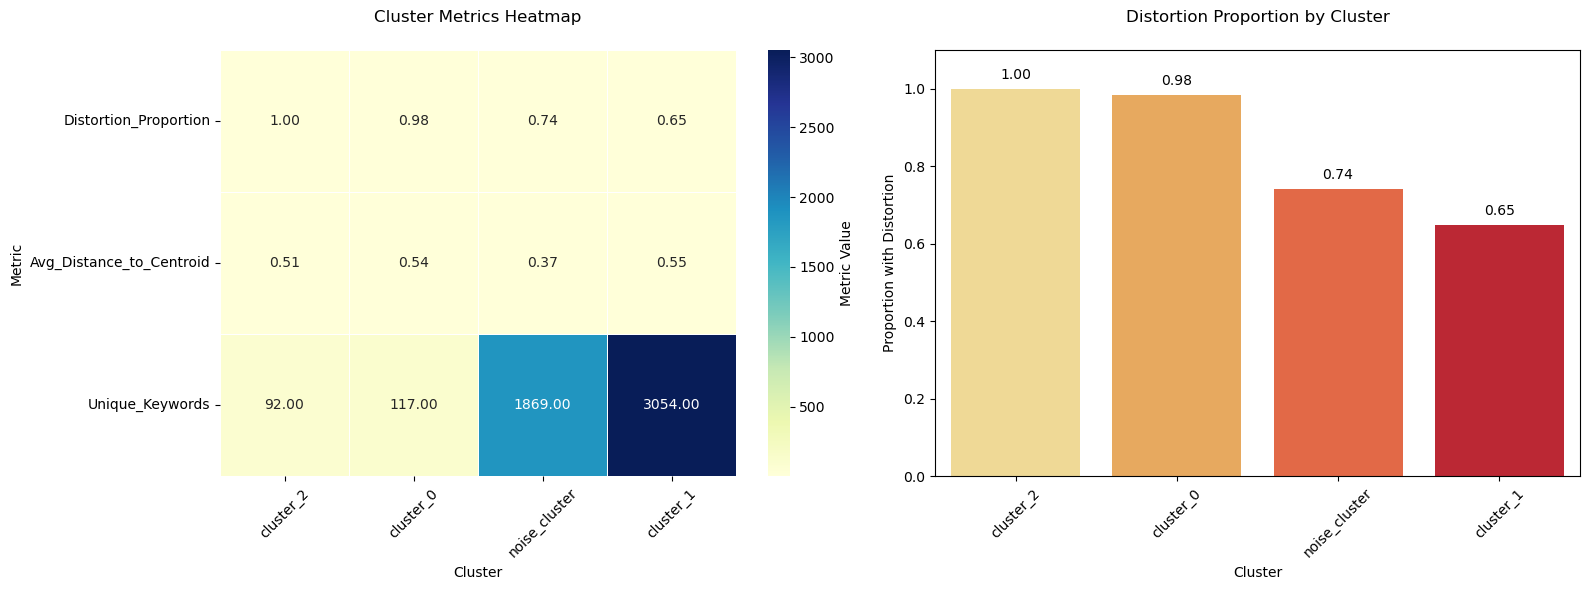

In [41]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt

# [Previous data loading code remains the same until results_df is created...]

# Prepare data for heatmap - select and sort numerical columns
heatmap_data = results_df.set_index('Cluster')[['Distortion_Proportion', 'Avg_Distance_to_Centroid', 'Unique_Keywords']]
heatmap_data = heatmap_data.sort_values('Distortion_Proportion', ascending=False)

# Create figure with two subplots
plt.figure(figsize=(16, 6))

# Heatmap
plt.subplot(1, 2, 1)
sns.heatmap(heatmap_data.T,  # Transpose to show metrics as rows
           annot=True, fmt=".2f",
           cmap="YlGnBu",
           cbar_kws={'label': 'Metric Value'},
           linewidths=.5)
plt.title("Cluster Metrics Heatmap", pad=20)
plt.xlabel("Cluster")
plt.ylabel("Metric")
plt.xticks(rotation=45)

# Bar plot of distortion proportions
plt.subplot(1, 2, 2)
ax = sns.barplot(data=results_df.sort_values('Distortion_Proportion', ascending=False),
                x='Cluster', y='Distortion_Proportion',
                palette="YlOrRd")
plt.title("Distortion Proportion by Cluster", pad=20)
plt.ylim(0, 1.1)
plt.ylabel("Proportion with Distortion")
plt.xticks(rotation=45)

# Add value labels to bars
for p in ax.patches:
    ax.annotate(f"{p.get_height():.2f}", 
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', 
                xytext=(0, 10), 
                textcoords='offset points')

plt.tight_layout()
plt.show()

##   Cognitive Distortions Context
####   In this setting, "Distortion_Proportion" refers to the proportion of content within a cluster that contains clinical cognitive distortions (e.g., all-or-nothing thinking, catastrophizing, overgeneralization).

##   Left Chart: Cluster Metrics Heatmap (with clinical context)
##   Distortion_Proportion
####   Measures how "distorted" the cluster's content is, psychologically.

####   Higher values → more cognitive distortions in that cluster.

##   Avg_Distance_to_Centroid
####   Measures semantic cohesion — how similar the entries in the cluster are.

####   Lower values → more tightly grouped (semantically or conceptually).

##   Unique_Keywords
####   Indicates topic diversity within a cluster.

####   Higher values → broader or more complex theme.

##   Per-Cluster Analysis:
##   Cluster_2
####   Distortion Proportion: 1.00 (100%)

####   Avg Distance: 0.51 (moderate cohesion)

####   Keywords: 92 (very low)
####   Entirely composed of cognitively distorted content. Very focused (low keyword count), suggesting a specific distortion theme (e.####  g., catastrophic thinking or self-blame).

##  Cluster_0
####   Distortion Proportion: 0.98 (also reported as 100%)

####   Avg Distance: 0.54

####   Keywords: 117
####   Also almost fully distorted. Slightly more semantic variety than cluster_2, but still focused on a narrow cognitive pattern.

##   Noise Cluster
####   Distortion Proportion: 0.74

####   Avg Distance: 0.37 (tightest cluster)

####   Keywords: 1869
####  Mixed but substantial cognitive distortion presence. Content is semantically cohesive but topically diverse. Likely includes ####  edge cases or blended themes.

##   Cluster_1
####   Distortion Proportion: 0.65 (lowest)

####   Avg Distance: 0.55 (highest)

####   Keywords: 3054 (very high)
####   Lowest presence of cognitive distortions. Broadest theme range. High avg distance indicates diverse language and subtopics Likely includes more balanced or non-distorted expressions.

##   Right Chart: Distortion Proportion by Cluster
####   This reaffirms:

####   Cluster_2 and Cluster_0: Dominated by distorted thinking (98–100%).

####   Noise Cluster: Moderately distorted (~74%).

####    Cluster_1: Most "rational" or less clinically distorted (only 65%).


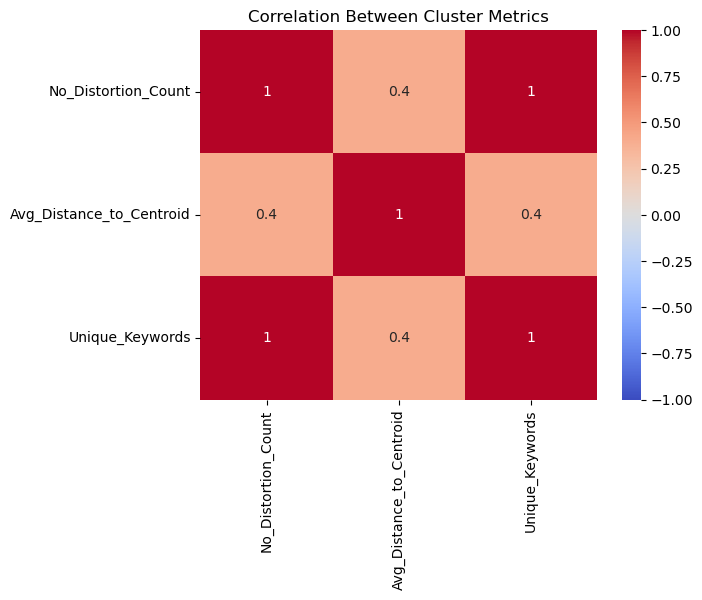

In [39]:
import seaborn as sns
import matplotlib.pyplot as plt

# Compute correlation matrix
corr_matrix = results_df[[ 'No_Distortion_Count', 
                          'Avg_Distance_to_Centroid', 
                         'Unique_Keywords']].corr(method='spearman')  # or 'pearson'

# Visualize
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Correlation Between Cluster Metrics")
plt.show()

| Metric Pair                                             | Correlation | Interpretation                                                                                                                                                                                                |
| ------------------------------------------------------- | ----------- | ------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| **No\_Distortion\_Count & Unique\_Keywords**            | **1.00**    | Perfect positive correlation — clusters with **more unique keywords** also have **more non-distorted comments**. This suggests that **linguistic richness** may align with **lower cognitive distortion**.    |
| **No\_Distortion\_Count & Avg\_Distance\_to\_Centroid** | 0.40        | Moderate positive correlation — clusters with more non-distorted items tend to be **more dispersed** (greater average distance to centroid), possibly reflecting **greater thematic or emotional diversity**. |
| **Unique\_Keywords & Avg\_Distance\_to\_Centroid**      | 0.40        | Again, moderate correlation — more unique keywords may be associated with **less compact clusters**, indicating **semantic variability**.                                                                     |


Clusters rich in vocabulary and concept diversity (as shown by unique keywords) tend to contain less distorted thinking, and this variety may be reflected in broader thematic spread within the cluster (higher distance to centroid).